In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
from scipy import signal
from typing import Callable
import heapq
import sys
import types

In [3]:
img = cv2.imread("1.jpg")
OBJECT_IMG = img[850:, 1450:]
TARGET_IMG = img[:, :1400]

In [4]:
def greater(value1: int | np.ndarray, value2: int | np.ndarray):
    if isinstance(value1, np.ndarray):
        for i in range(len(value1)):
            if (value1[i] != value2[i]):
                return value1[i] > value2[i]
    return value1 > value2
        
def extract_single(object_img: np.ndarray, threshold: int = 0, step: int = 4):
    # print(object_img[0, 0])
    img_h, img_w = object_img.shape[:2]
    detected_x = -1
    detected_y = -1
    for x in range(img_w):
        for y in range(img_h):
            if not greater(object_img[y, x], threshold):
                detected_x = x
                detected_y = y
                break
        if detected_x != -1:
            break
    left_x = detected_x
    right_x = detected_x
    up_y = detected_y
    down_y = detected_y
    def check_complete(left: int, right: int, up: int, down: int):
        line1 = object_img[up, left:right]
        line2 = object_img[down, left:right]
        line3 = object_img[up:down, left]
        line4 = object_img[up:down, right]
        border = list(line1) + list(line2) + list(line3) + list(line4)
        if len(border) == 0: return False
        return all(greater(v, threshold) for v in border)
    interation = 0
    while not check_complete(left_x, right_x, up_y, down_y):
        if interation == 0 or not all(greater(v, threshold) for v in object_img[up_y:down_y, left_x]):
            while True:
                left_x = max(0, left_x-step)
                if left_x == 0: break
                slice = object_img[up_y:down_y, left_x-step:left_x]
                if len(slice.shape) == 3:
                    arr_range = list(slice.reshape(-1, slice.shape[-1]))
                else:
                    arr_range = list(slice.flatten())
                if all(greater(v, threshold) for v in arr_range): break
        if interation == 0 or not all(greater(v, threshold) for v in object_img[up_y:down_y, right_x]):
            while True:
                right_x = min(img_w-1, right_x+step)
                if right_x == img_w - 1: break
                slice = object_img[up_y:down_y, right_x:right_x+step]
                if len(slice.shape) == 3:
                    arr_range = list(slice.reshape(-1, slice.shape[-1]))
                else:
                    arr_range = list(slice.flatten())
                try:
                    if all(greater(v, threshold) for v in arr_range): break
                except:
                    print(threshold, arr_range)
        if interation == 0 or not all(greater(v, threshold) for v in object_img[up_y, left_x:right_x]):
            while True:
                up_y = max(0, up_y-step)
                if up_y == 0: break
                slice = object_img[up_y-step:up_y, left_x:right_x]
                if len(slice.shape) == 3:
                    arr_range = list(slice.reshape(-1, slice.shape[-1]))
                else:
                    arr_range = list(slice.flatten())
                if all(greater(v, threshold) for v in arr_range): break
        if interation == 0 or  not all(greater(v, threshold) for v in object_img[down_y, left_x:right_x]):
            while True:
                down_y = min(img_h-1, down_y+step)
                if down_y == img_h - 1: break
                slice = object_img[down_y:down_y+step, left_x:right_x]
                if len(slice.shape) == 3:
                    arr_range = list(slice.reshape(-1, slice.shape[-1]))
                else:
                    arr_range = list(slice.flatten())
                if all(greater(v, threshold) for v in arr_range): break
        interation += 1
        if interation > 100: break
    print(interation, left_x, up_y, right_x, down_y)
    return object_img[up_y:down_y, left_x:right_x], (left_x, right_x, up_y, down_y)
def extract(object_image: np.ndarray, threshold: int = 0, step: int = 4, amount: int = 15):
    img = object_image.copy().astype(np.int32)
    object_images: list[np.ndarray] = []
    for _ in range(amount):
        object_img, (left, right, up, down) = extract_single(img, threshold, step)
        object_images.append(object_img.copy())
        img[up:down, left:right] = 255
    return object_images

3 48 326 280 526
2 55 68 191 284
3 63 558 231 710
2 75 756 187 876
2 265 51 473 291
2 317 568 485 672
3 319 742 431 878
2 387 371 571 499
(230, 230, 230) [array([254, 253, 255]), array([254, 251, 253]), array([249, 246, 248]), array([255, 254, 255]), array([254, 255, 251]), array([247, 251, 239]), array([255, 255, 247]), array([230, 230, 230]), array([254, 252, 255]), array([254, 250, 255]), array([248, 245, 247]), array([255, 254, 255]), array([255, 255, 254]), array([250, 254, 243]), array([255, 255, 249]), array([238, 237, 241]), array([254, 251, 255]), array([255, 252, 255]), array([246, 242, 247]), array([255, 254, 255]), array([255, 255, 255]), array([252, 255, 246]), array([255, 255, 251]), array([245, 243, 249]), array([254, 253, 255]), array([255, 253, 255]), array([245, 242, 244]), array([255, 254, 255]), array([255, 255, 255]), array([252, 253, 249]), array([255, 255, 254]), array([249, 245, 255]), array([254, 254, 254]), array([255, 255, 255]), array([245, 242, 244]), array

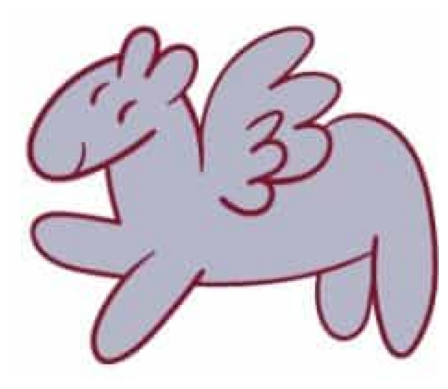

(216, 136, 3)


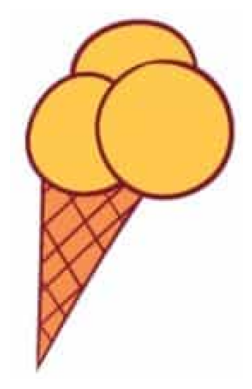

(152, 168, 3)


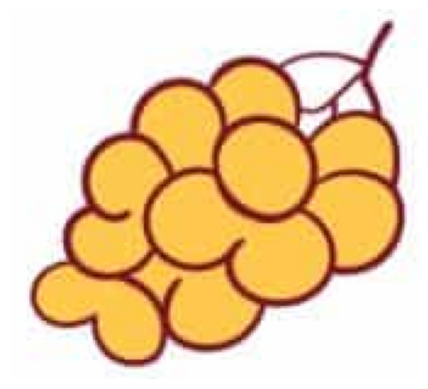

(120, 112, 3)


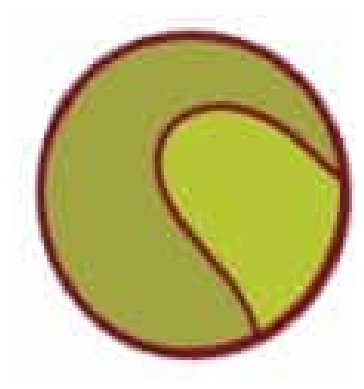

(240, 208, 3)


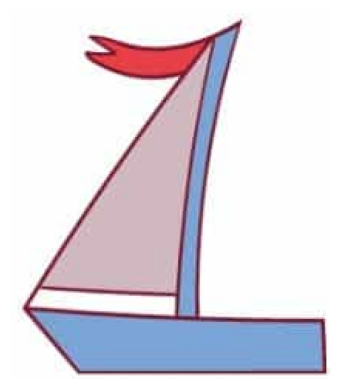

(104, 168, 3)


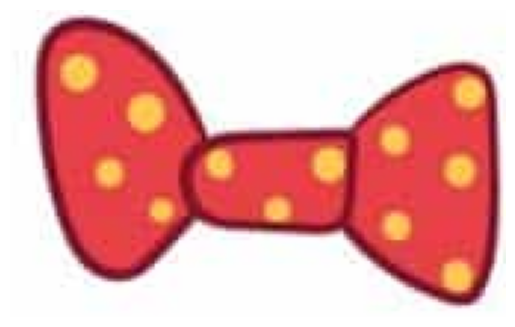

(136, 112, 3)


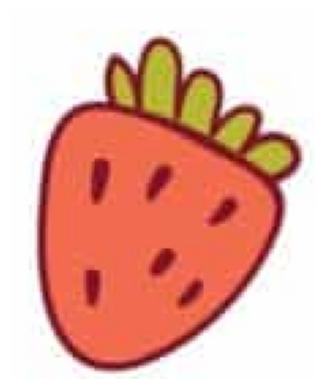

(128, 184, 3)


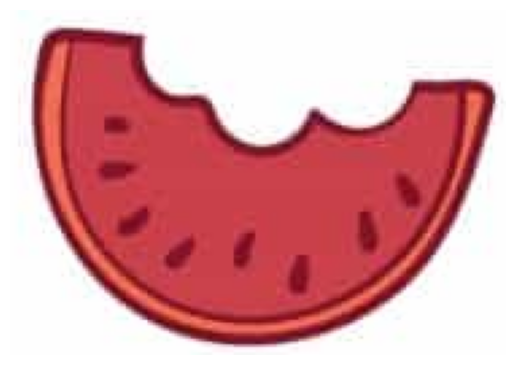

(160, 224, 3)


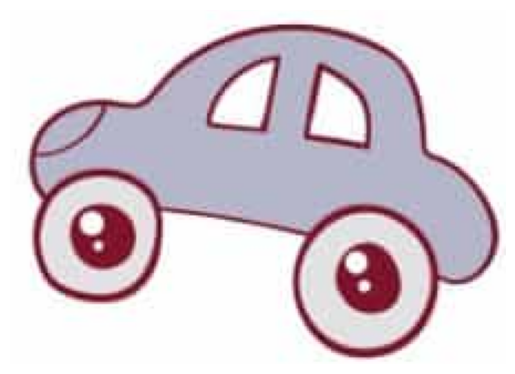

(352, 240, 3)


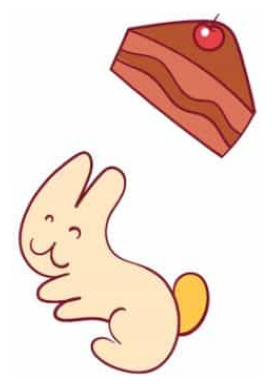

(200, 208, 3)


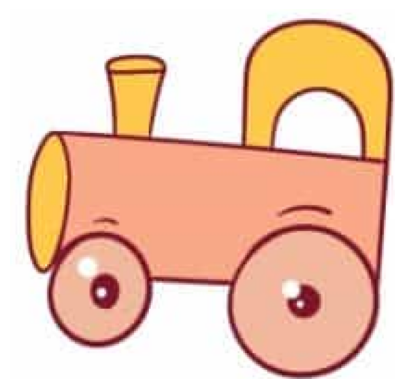

(336, 248, 3)


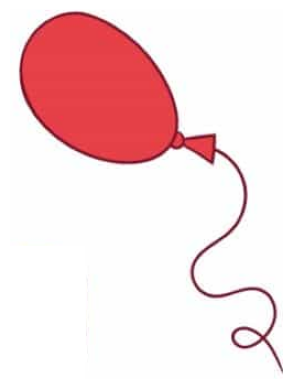

(152, 184, 3)


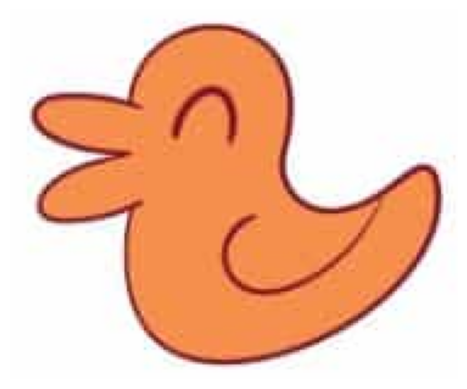

(224, 168, 3)


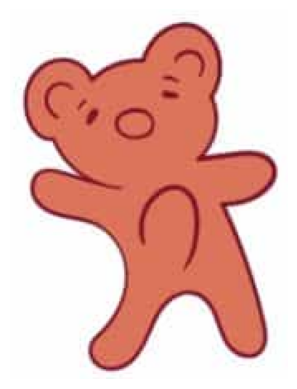

In [6]:
OBJECT_IMGS = extract(OBJECT_IMG, (230, 230, 230), 8, 14)
for extracted_img in OBJECT_IMGS:
    print(extracted_img.shape)
    plt.imshow(extracted_img[:, :, ::-1])
    plt.axis("off")
    plt.show(True)